In [1]:
!pip install optuna
!pip install optuna-integration[sklearn]
!pip install phik

     |████████████████████████████████| 383 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 2.9 MB/s eta 0:00:011
     |████████████████████████████████| 686 kB 2.1 MB/s eta 0:00:01


In [2]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.11.0

     |████████████████████████████████| 9.6 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 235 kB 62.9 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 93.0 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import (train_test_split, RandomizedSearchCV,
                                     GridSearchCV)
from sklearn.preprocessing import (OneHotEncoder, LabelEncoder, OrdinalEncoder,
                                   StandardScaler, MinMaxScaler)
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import (mean_absolute_error, r2_score, mean_squared_error,
                             accuracy_score, roc_auc_score, confusion_matrix,
                             recall_score, precision_score, make_scorer)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.feature_selection import (SelectKBest, mutual_info_regression,
                                       mutual_info_classif)
from optuna import distributions
from optuna.integration import OptunaSearchCV

from phik.report import plot_correlation_matrix
from phik import report
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [4]:
RANDOM_STATE = 42

# Выбор локации для скважины

## Введение

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## План работы

1. Загрузка и подготовка данных

2. Обучение и проверка модели для каждого региона

3. Подготовка к расчёту прибыли

4. Расчёт прибыли по выбранным скважинам

5. Оценка рисков и прибыли для каждого региона


## Загрузка и подготовка данных

### Загрузка даных

In [5]:
first_region = pd.read_csv('/datasets/geo_data_0.csv')
second_region = pd.read_csv('/datasets/geo_data_1.csv')
third_region = pd.read_csv('/datasets/geo_data_2.csv')
datasets = [first_region, second_region, third_region]
datasets_str = ['first_region', 'second_region', 'third_region']

Создадим функцию для более подробного изучения первчиной информации

In [6]:
def data_info(dataset):
    print("Первые строки датафрейма")
    display(dataset.head())
    print('\n\nПервичная информация')
    dataset.info()
    print('-' * 50)
    print('\n\n')

In [7]:
for i, dataset in enumerate(datasets):
    print(datasets_str[i])
    data_info(dataset)

first_region
Первые строки датафрейма


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647




Первичная информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
--------------------------------------------------



second_region
Первые строки датафрейма


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305




Первичная информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
--------------------------------------------------



third_region
Первые строки датафрейма


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746




Первичная информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
--------------------------------------------------





### Поиск дубликатов

In [8]:
for i, dataset in enumerate(datasets):
    print(f"{datasets_str[i]}: {dataset.duplicated(subset = ['id']).sum()}")

first_region: 10
second_region: 4
third_region: 4


Удалим дубликаты с одинаковым уникальным идентификатором скважины

In [9]:
for i, dataset in enumerate(datasets):
    dataset.drop_duplicates(subset = ['id'], keep='first', inplace = True)
    print(f"{datasets_str[i]}: {dataset['id'].duplicated().sum()}")

first_region: 0
second_region: 0
third_region: 0


In [10]:
for dataset in datasets:
    dataset.set_index('id', inplace=True)

### Вывод

Удалены дубликаты

## Исследовательский анализ данных

Создадим функцию для исследования данных

In [11]:
num_columns = (first_region.select_dtypes(include=['int64', 'float64']))

In [12]:
datasets = [first_region, second_region, third_region]

In [13]:
datasets_str

['first_region', 'second_region', 'third_region']

first_region
                 f0            f1            f2       product
count  99990.000000  99990.000000  99990.000000  99990.000000
mean       0.500454      0.250141      2.502629     92.499684
std        0.871844      0.504430      3.248149     44.288304
min       -1.408605     -0.848218    -12.088328      0.000000
25%       -0.072572     -0.200877      0.287784     56.497069
50%        0.502405      0.250252      2.515969     91.847928
75%        1.073626      0.700640      4.715035    128.563699
max        2.362331      1.343769     16.003790    185.364347


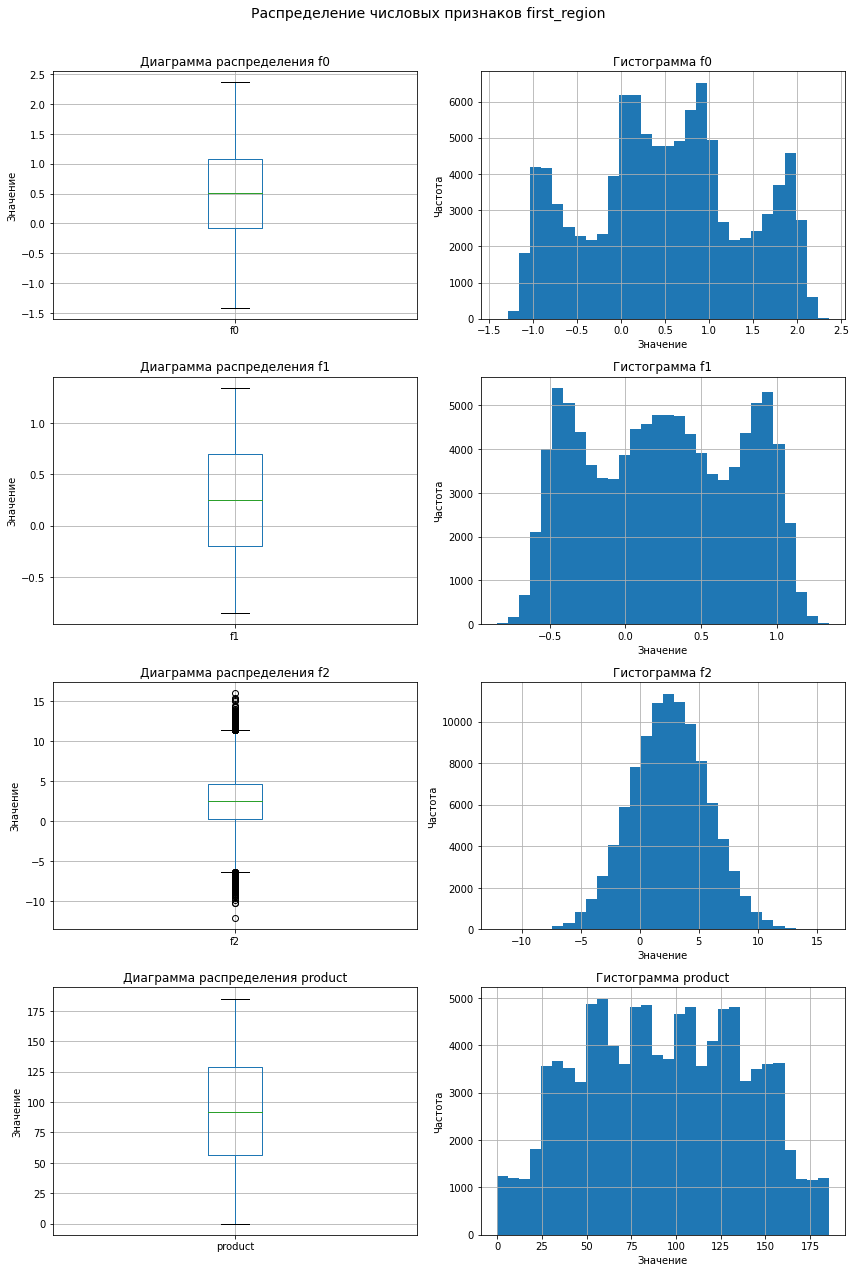


-------------------
second_region
                 f0            f1            f2       product
count  99996.000000  99996.000000  99996.000000  99996.000000
mean       1.141209     -4.796608      2.494501     68.823916
std        8.965815      5.119906      1.703579     45.944663
min      -31.609576    -26.358598     -0.018144      0.000000
25%       -6.298551     -8.267985      1.000021     26.953261
50%        1.153055     -4.813172      2.011475     57.085625
75%        8.620964     -1.332816      3.999904    107.813044
max       29.421755     18.734063      5.019721    137.945408


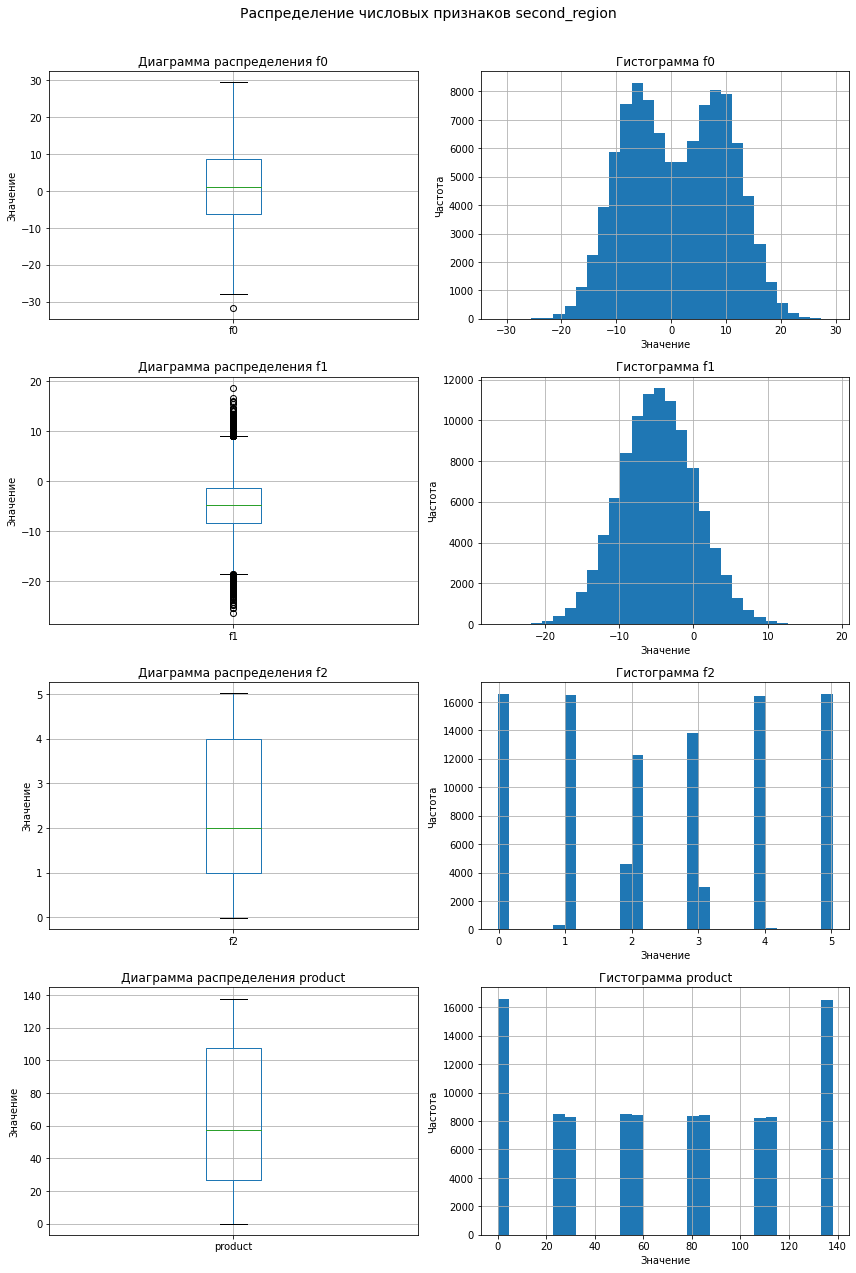


-------------------
third_region
                 f0            f1            f2       product
count  99996.000000  99996.000000  99996.000000  99996.000000
mean       0.002002     -0.002159      2.495084     94.998342
std        1.732052      1.730397      3.473482     44.749573
min       -8.760004     -7.084020    -11.970335      0.000000
25%       -1.162328     -1.174841      0.130269     59.450028
50%        0.009424     -0.009661      2.484236     94.925026
75%        1.158477      1.163523      4.858720    130.586815
max        7.238262      7.844801     16.739402    190.029838


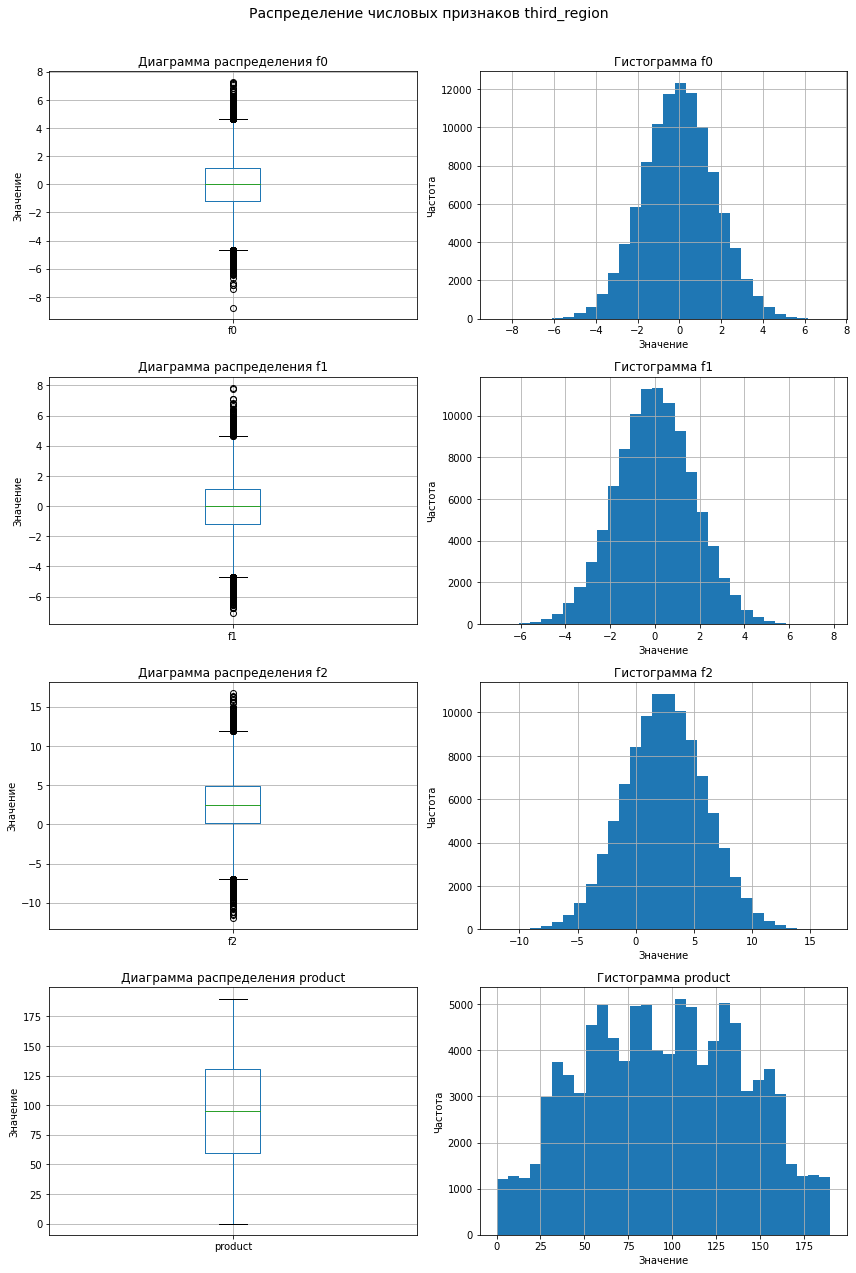


-------------------


In [14]:
for dataset, name in zip(datasets, datasets_str):
    print(name)
    print(dataset.describe())
    fig, axes = plt.subplots(4, 2, figsize=(12, 18))
    fig.suptitle(f'Распределение числовых признаков {name}', fontsize=14)
    
    for i, col in enumerate(num_columns):
        dataset[col].plot.box(ax=axes[i][0])
        axes[i][0].set_title(f'Диаграмма распределения {col}')
        axes[i][0].grid(True)
        axes[i][0].set_ylabel('Значение')
        
        dataset[col].plot.hist(bins=30, ax=axes[i][1])
        axes[i][1].set_title(f'Гистограмма {col}')
        axes[i][1].grid(True)
        axes[i][1].set_ylabel('Частота')
        axes[i][1].set_xlabel('Значение')
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    print("\n-------------------")

In [15]:
first_region.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99990 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99990 non-null  float64
 1   f1       99990 non-null  float64
 2   f2       99990 non-null  float64
 3   product  99990 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


## Корреляционный анализ

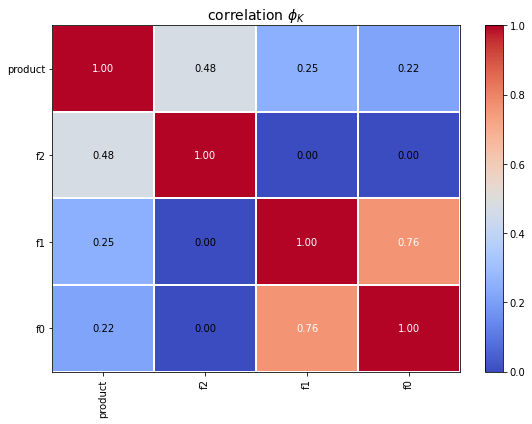

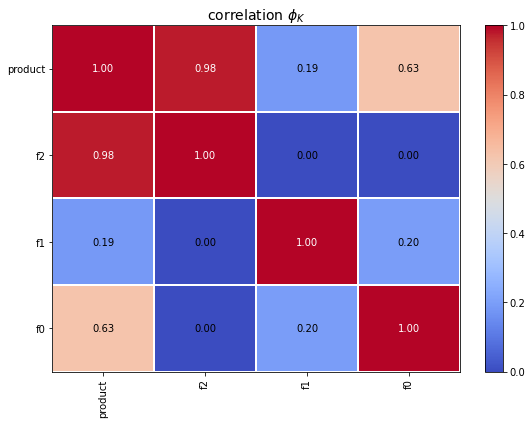

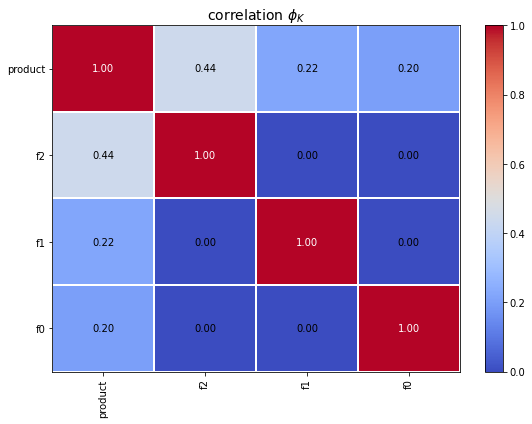

In [16]:

interval_cols = ['f0','f1', 'f2', 'product']
for dataset, name in zip(datasets, datasets_str):
    phik_overview = dataset.phik_matrix(interval_cols=interval_cols)
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='coolwarm',
        title=r'correlation $\phi_K$',
        figsize=(8, 6)
    ) 

Заметим, что во втором регионе коэффициент корреляции между `f2` и целевым признаком `product` 0.98, что говорит об очень высокой зависимости

## Обучение и проверка модели

### Подготовка

Разобьем данные каждого региона на обучающие и валидационные выборки

In [17]:
TEST_SIZE = 0.25

In [18]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    first_region.drop('product', axis=1),
    first_region['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    second_region.drop('product', axis=1),
    second_region['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    third_region.drop('product', axis=1),
    third_region['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

Подготовтим пайплайн для предобработки и обучения

In [19]:
num_columns = ['f0', 'f1', 'f2']

In [20]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', MinMaxScaler())
])
target_scaler = FunctionTransformer(lambda y: MinMaxScaler().fit_transform(y.reshape(-1, 1)), validate=False)

In [21]:
data_preprocessor = ColumnTransformer([
    ('num', num_pipe, num_columns)
])

In [22]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [23]:
param_grid = [
    {
    'models': [LinearRegression()],
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
    'models': [Ridge()],
    'models__alpha': range(1, 5),
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
    'models': [Lasso()],
    'models__alpha': range(1, 5),
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
    
]

### Первый регион

In [24]:
randomized_search_1 = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=10,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_1.fit(X_train_1, y_train_1)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['f0',
                                                                                'f1',
                                                                                'f2'])])),
                                             ('models', LinearRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LinearRegression()],
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']},
                                        {'models': [Ridge(alpha=3)],
                                         'models__alpha': range(1, 5),
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']},
                                        {'models': [Lasso()],
                                         'models__alpha': range(1, 5),
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [25]:
print('Лучшая модель и её параметры:\n\n', randomized_search_1.best_estimator_)
print ('Метрика лучшей модели с кросс-валидацией:', -randomized_search_1.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   'passthrough')]),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', Ridge(alpha=3))])
Метрика лучшей модели с кросс-валидацией: 37.69622930190594


In [26]:
model_1 = randomized_search_1.best_estimator_
y_pred_1 = model_1.predict(X_test_1)
print(f"Средний запас предсказанного сырья: {y_pred_1.mean()}")
print(f"RMSE = {mean_squared_error(y_test_1, y_pred_1, squared=False)}")

Средний запас предсказанного сырья: 92.60983044819855
RMSE = 37.68508883499026


### Второй регион

In [27]:
randomized_search_2 = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=10,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_2.fit(X_train_2, y_train_2)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['f0',
                                                                                'f1',
                                                                                'f2'])])),
                                             ('models', LinearRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LinearRegression()],
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']},
                                        {'models': [Ridge(alpha=3)],
                                         'models__alpha': range(1, 5),
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']},
                                        {'models': [Lasso()],
                                         'models__alpha': range(1, 5),
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [28]:
print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_)
print ('Метрика лучшей модели с кросс-валидацией:', -randomized_search_2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели с кросс-валидацией: 0.8895937454503166


In [29]:
model_2 = randomized_search_2.best_estimator_
y_pred_2 = model_2.predict(X_test_2)
print(f"Средний запас предсказанного сырья: {y_pred_2.mean()}")
print(f"RMSE = {mean_squared_error(y_test_2, y_pred_2, squared=False)}")

Средний запас предсказанного сырья: 68.57703454115173
RMSE = 0.8928265978121422


### Третий регион

In [30]:
randomized_search_3 = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=10,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_3.fit(X_train_3, y_train_3)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['f0',
                                                                                'f1',
                                                                                'f2'])])),
                                             ('models', LinearRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LinearRegression()],
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']},
                                        {'models': [Ridge(alpha=4)],
                                         'models__alpha': range(1, 5),
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']},
                                        {'models': [Lasso()],
                                         'models__alpha': range(1, 5),
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [31]:
print('Лучшая модель и её параметры:\n\n', randomized_search_3.best_estimator_)
print ('Метрика лучшей модели с кросс-валидацией:', -randomized_search_3.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', Ridge(alpha=4))])
Метрика лучшей модели с кросс-валидацией: 40.048159811020476


In [32]:
model_3 = randomized_search_3.best_estimator_
y_pred_3 = model_3.predict(X_test_3)
print(f"Средний запас предсказанного сырья: {y_pred_3.mean()}")
print(f"RMSE = {mean_squared_error(y_test_3, y_pred_3, squared=False)}")

Средний запас предсказанного сырья: 94.93478603297079
RMSE = 40.08081854413154


### Вывод

Среднее отклонение моделей для 1 и 3 региона практически одинаковы, однако заметим, что RMSE Для второго региона очень мало из-за того, что прзнак `f2` имеет высокую корреляцию с целевым признаком

Однако, несмотря на то, что RMSE Для второго региона очень мало, средние запасы во втором регионе составляют всего лишь 68.57, когда в 1 и 3 регионах запасы составляют 92.6 и 94.93 соответственно

## Подготовка к расчёту прибыли

In [33]:
budget = 10_000_000_000
per_unit = 450_000
num_to_choose = 200

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.


In [34]:
# Безубыточный обьем сырья для разработки скважины
print(f"Безубыточный обьем сырья для разработки скважины {round(budget / per_unit / num_to_choose, 2)}")

Безубыточный обьем сырья для разработки скважины 111.11


Для всех регионов средний запас меньше безубыточного объёма сырья

Второй регион имеет средний запас 68.57 тыс. баррелей, что ниже, чем в первом (92.6 тыс. баррелей) и третьем регионах (94.93 тыс. баррелей).

In [35]:
y_test_1 = pd.Series(y_test_1.reset_index(drop=True))
y_pred_1 = pd.Series(y_pred_1)

y_test_2 = pd.Series(y_test_2.reset_index(drop=True))
y_pred_2 = pd.Series(y_pred_2)

y_test_3 = pd.Series(y_test_3.reset_index(drop=True))
y_pred_3 = pd.Series(y_pred_3)

In [36]:
y_test_1, y_pred_1

(0        119.813252
 1        133.296862
 2         25.310435
 3         65.422491
 4        140.851476
             ...    
 24993    106.423368
 24994    109.320665
 24995     81.920694
 24996    147.910750
 24997    120.497955
 Name: product, Length: 24998, dtype: float64,
 0        127.487893
 1        116.463812
 2         66.042243
 3         45.010931
 4        124.536767
             ...    
 24993    105.377604
 24994    110.380796
 24995     64.840244
 24996     92.865415
 24997     97.137524
 Length: 24998, dtype: float64)

## Расчёт прибыли и рисков 

Напишем функцию для расчета прибыли по выбранным скважинам

In [37]:
def revenue(target, preds):
    preds_sorted = preds.sort_values(ascending=False)
    selected = target[preds_sorted.index][:num_to_choose]
    return round(selected.sum() * per_unit - budget,2)

In [38]:
print(f"Прибыль с 1 региона {revenue(y_test_1, y_pred_1)}")
print(f"Прибыль с 2 региона {revenue(y_test_2, y_pred_2)}")
print(f"Прибыль с 3 региона {revenue(y_test_3, y_pred_3)}")

Прибыль с 1 региона 3468529787.42
Прибыль с 2 региона 2415086696.68
Прибыль с 3 региона 2396613000.94


Применим bootstrap

In [39]:
from numpy.random import RandomState

In [40]:

def bootstrap(target, preds, n_samples=1000, sample_size=500):
    values = []
    state = RandomState(12345) 
    for i in range(n_samples):
        target_subsample = target.sample(sample_size, replace=True, random_state=state)
        preds_subsample = preds[target_subsample.index]   
        values.append(revenue(target_subsample, preds_subsample))

    values = np.array(values)

    # Средняя прибыль
    mean_profit = np.mean(values)

    # 95%-й доверительный интервал
    lower_bound = np.percentile(values, 2.5)
    upper_bound = np.percentile(values, 97.5)

    # Риск убытков (процент выборок, где прибыль < 0)
    risk_of_loss = np.mean(values < 0)

    print(f"Средняя прибыль: {mean_profit:.2f}")
    print(f"95%-й доверительный интервал: ({lower_bound:.2f}, {upper_bound:.2f})")
    print(f"Риск убытков: {risk_of_loss:.2%}")

    #return mean_profit, (lower_bound, upper_bound), risk_of_loss

In [41]:
bootstrap(y_test_1, y_pred_1)

Средняя прибыль: 447498475.58
95%-й доверительный интервал: (-91012463.00, 997543755.91)
Риск убытков: 5.30%


In [42]:
bootstrap(y_test_2, y_pred_2)

Средняя прибыль: 491068525.64
95%-й доверительный интервал: (95228849.67, 960072434.74)
Риск убытков: 0.70%


In [43]:
bootstrap(y_test_3, y_pred_3)

Средняя прибыль: 383786040.13
95%-й доверительный интервал: (-180217703.84, 916980805.32)
Риск убытков: 7.80%


### Вывод

**Выводы и рекомендации**  

**Анализ регионов**  
**Первый регион**  
- **Средняя прибыль:** 447.5 млн  
- **95%-й доверительный интервал:** (-91.0 млн, 997.5 млн)  
- **Риск убытков:** 5.3%  

**Второй регион**  
- **Средняя прибыль:** 491.1 млн  
- **95%-й доверительный интервал:** (95.2 млн, 960.1 млн)  
- **Риск убытков:** 0.7%  

**Третий регион**  
- **Средняя прибыль:** 383.8 млн  
- **95%-й доверительный интервал:** (-180.2 млн, 916.9 млн)  
- **Риск убытков:** 7.8%  

**Оценка рисков**  
Согласно условиям, рассматриваем только регионы, где **риск убытков < 2.5%**.  
 **Первый регион (5.3%)** и **третий регион (7.8%)** исключаются, так как их риски выше допустимого.  
 **Второй регион (0.7%)** проходит отбор, так как вероятность убытков минимальна.  

**Окончательный выбор региона**  
 **Рекомендуемый регион для разработки: Второй регион.**  

**Причины выбора:**  
 Самый низкий риск убытков (**0.7%**).   
 Стабильность прогнозов из-за высокой корреляции `f2` с целевым признаком.  

## Вывод


1. **Задача** Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль

2. В исходных данных удалены дубликаты
3. Для поиска лучшей модели был собран пайплайн, который включает в себя преодобработку данных, а также само обучение, далее запущен рандомизированных поиск с подбором гиперпараметров для модели LinearRegression() и с регуляризацией RIdge и Lasso: 
4. 
    + Лучшей моделью для 1 региона оказалось Ridge(alpha=3)
    + Лучшей моделью для 2 региона оказалось LinearRegression()
    + Лучшей моделью для 3 региона оказалось Ridge(alpha=4)

5. Посчитаны риски и прибыль для каждого региона:
    + **Окончательный выбор региона**  
     **Рекомендуемый регион для разработки: Второй регион.** 